<a href="https://colab.research.google.com/github/LCaravaggio/AnalisisCuantitativoAvanzado/blob/main/S%26W_Chp14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Esta notebook se propone replicar con datos de Argentina el Capítulo 14 de Stock y Watson (2006).



# Carga de datos

In [1]:
from google.colab import drive
import json

import requests
from requests.auth import HTTPBasicAuth

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/alphacast.json", 'r') as f:
    api_token= json.load(f)

Mounted at /content/drive


In [3]:
# Definir user key para la API
user_key = api_token["key"]     

In [4]:
# Desocupados
desocup = requests.get('https://api.alphacast.io/datasets/6144/data?apiKey='+user_key+'&&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('desocup.csv','wb').write(desocup.content)
desocup = pd.read_csv('desocup.csv',delimiter = ',')
desocup = desocup.loc[54:]

In [5]:
infla = requests.get('https://api.alphacast.io/drafts/615-1677091841985?apiKey='+user_key, auth=HTTPBasicAuth(user_key, ''))
open('infla.csv','wb').write(infla.content)
infla = pd.read_csv('infla.csv',delimiter = ',')

# Figura 14.1

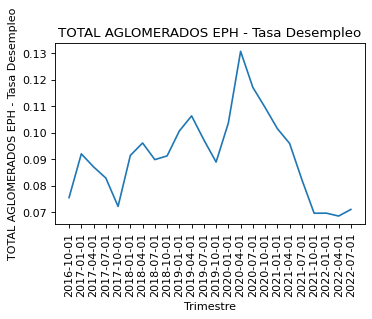

In [6]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(5, 3), dpi=80)
variable=desocup['TOTAL AGLOMERADOS EPH - Tasa Desempleo']
fig = sns.lineplot(x=desocup.Date, y=variable)
plt.title(variable.name)
plt.xlabel("Trimestre")
plt.xticks(rotation=90)
plt.savefig('%s.png'%variable.name)

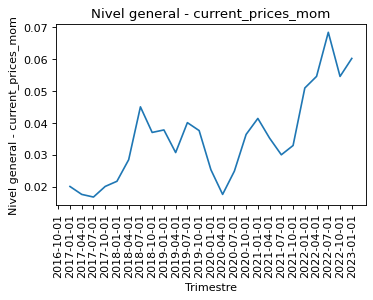

In [7]:
figure(figsize=(5, 3), dpi=80)
variable=infla['Nivel general - current_prices_mom']/100
fig = sns.lineplot(x=infla.Date, y=variable)
plt.title(variable.name)
plt.xlabel("Trimestre")
plt.xticks(rotation=90)
plt.savefig('%s.png'%variable.name)

# Modelo autoregresivo: AR

In [8]:
datos=pd.DataFrame({"infla":list(infla['Nivel general - current_prices_mom'][1:-2]/100), "desocup":list(desocup['TOTAL AGLOMERADOS EPH - Tasa Desempleo'][1:])}, index=infla['Date'][1:-2])

In [9]:
from statsmodels.tsa.api import AutoReg
ar_model = AutoReg(datos['infla'], lags=1, old_names=True).fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


In [10]:
# Estos valores aparecen, para el caso de EEUU, en la ecuación 14.7
ar_model.params

intercept    0.004685
infla.L1     0.922209
dtype: float64

Es decir que se trata de los parámetros estimados para la ecuación 14.8 \
$Y_t=\beta_0+\beta_1Y_{t-1}+u_t$

In [11]:
ar_model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  infla   No. Observations:                   23
Model:                     AutoReg(1)   Log Likelihood                  74.637
Method:               Conditional MLE   S.D. of innovations              0.008
Date:                Thu, 23 Feb 2023   AIC                             -9.350
Time:                        16:05:39   BIC                             -9.202
Sample:                    04-01-2017   HQIC                            -9.315
                         - 07-01-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0047      0.006      0.850      0.395      -0.006       0.015
infla.L1       0.9222      0.164      5.633      0.000       0.601       1.243
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0844           +0.0000j            1.0844            0.0000
-----------------------------------------------------------------------------
"""

In [12]:
# Con este modelo sería posible hacer una predicción para el siguiente valor aún no observado 
yhat = ar_model.predict(len(variable), len(variable))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Esta predicción se presenta en el texto en la ecuación 14.9 \

$\hat{Y}_{t+1|t}=\beta_0+\beta_1Y_{t}$

In [13]:
yhat

2023-07-01    0.06619
Freq: QS-OCT, dtype: float64

Cuando se conozca el verdadero valor de $y_{t+1}$ será posible calcular el error de estimación, que se presenta en la ecuación 14.10: \

error=$Y_{t+1}-\hat{Y}_{t+1|t}$

# AR(p)

In [14]:
# El modelo 
ar_model = AutoReg(datos['infla'], lags=4, old_names=True).fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


In [15]:
# Los valores de esta salida corresponden a los presentados en la ecuación 14.13 
ar_model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  infla   No. Observations:                   23
Model:                     AutoReg(4)   Log Likelihood                  65.565
Method:               Conditional MLE   S.D. of innovations              0.008
Date:                Thu, 23 Feb 2023   AIC                             -9.108
Time:                        16:05:39   BIC                             -8.810
Sample:                    01-01-2018   HQIC                            -9.057
                         - 07-01-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0065      0.009      0.714      0.475      -0.011       0.024
infla.L1       0.9376      0.252      3.723      0.000       0.444       1.431
infla.L2      -0.0718      0.336     -0.213      0.831      -0.731       0.588
infla.L3      -0.4665      0.363     -1.286      0.199      -1.178       0.245
infla.L4       0.4929      0.275      1.793      0.073      -0.046       1.032
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2831           -0.0000j            1.2831           -0.5000
AR.2            1.0727           -0.0000j            1.0727           -0.0000
AR.3            0.5783           -1.0675j            1.2141           -0.1710
AR.4            0.5783           +1.0675j            1.2141            0.1710
-----------------------------------------------------------------------------
"""

In [16]:
datos['L1.desocup']=datos['desocup'].shift(1)

In [17]:
datos=datos.dropna()

In [18]:
ar_model = AutoReg(endog=datos['infla'], exog=datos['L1.desocup'], lags=4, old_names=False).fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


In [19]:
# Estos son los resultados de la ecuación 14.16
ar_model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  infla   No. Observations:                   22
Model:                   AutoReg-X(4)   Log Likelihood                  63.252
Method:               Conditional MLE   S.D. of innovations              0.007
Date:                Thu, 23 Feb 2023   AIC                             -9.088
Time:                        16:05:39   BIC                             -8.742
Sample:                    04-01-2018   HQIC                            -9.040
                         - 07-01-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0438      0.022      2.022      0.043       0.001       0.086
infla.L1       0.6607      0.278      2.374      0.018       0.115       1.206
infla.L2      -0.1456      0.318     -0.457      0.647      -0.770       0.478
infla.L3      -0.4588      0.343     -1.337      0.181      -1.132       0.214
infla.L4       0.4466      0.260      1.717      0.086      -0.063       0.956
L1.desocup    -0.2499      0.142     -1.764      0.078      -0.527       0.028
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2642           -0.0000j            1.2642           -0.5000
AR.2            0.4664           -1.0421j            1.1417           -0.1830
AR.3            0.4664           +1.0421j            1.1417            0.1830
AR.4            1.3587           -0.0000j            1.3587           -0.0000
-----------------------------------------------------------------------------
"""

In [20]:
datos['L2.desocup']=datos['desocup'].shift(2)
datos['L3.desocup']=datos['desocup'].shift(3)
datos['L4.desocup']=datos['desocup'].shift(4)
exog=['L1.desocup', 'L2.desocup', 'L3.desocup', 'L4.desocup']
datos=datos.dropna()

In [21]:
ar_model = AutoReg(endog=datos['infla'], exog=datos[exog], lags=4, old_names=False).fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


In [22]:
# Estos son los resultados de la ecuación 14.17
ar_model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  infla   No. Observations:                   18
Model:                   AutoReg-X(4)   Log Likelihood                  53.322
Method:               Conditional MLE   S.D. of innovations              0.005
Date:                Thu, 23 Feb 2023   AIC                             -9.027
Time:                        16:05:40   BIC                             -8.570
Sample:                    04-01-2019   HQIC                            -9.069
                         - 07-01-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1582      0.059      2.666      0.008       0.042       0.274
infla.L1       0.2707      0.393      0.689      0.491      -0.499       1.041
infla.L2      -0.2085      0.301     -0.693      0.489      -0.798       0.382
infla.L3      -0.8021      0.325     -2.470      0.013      -1.439      -0.166
infla.L4      -0.1861      0.407     -0.457      0.648      -0.984       0.612
L1.desocup    -0.4159      0.197     -2.115      0.034      -0.801      -0.030
L2.desocup     0.1874      0.234      0.800      0.424      -0.272       0.647
L3.desocup    -0.4948      0.245     -2.023      0.043      -0.974      -0.015
L4.desocup    -0.1898      0.244     -0.777      0.437      -0.669       0.289
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5323           -0.7886j            0.9514           -0.1555
AR.2            0.5323           +0.7886j            0.9514            0.1555
AR.3           -1.5537           -0.0000j            1.5537           -0.5000
AR.4           -3.8201           -0.0000j            3.8201           -0.5000
-----------------------------------------------------------------------------
"""

In [33]:
# Agrego todos los datos nuevamente
datos=pd.DataFrame({"infla":list(infla['Nivel general - current_prices_mom'][1:-2]/100), "desocup":list(desocup['TOTAL AGLOMERADOS EPH - Tasa Desempleo'][1:])}, index=infla['Date'][1:-2])
datos['D.Infla']=datos['infla']-datos['infla'].shift(1)
datos=datos.dropna()

# Figura 14.3

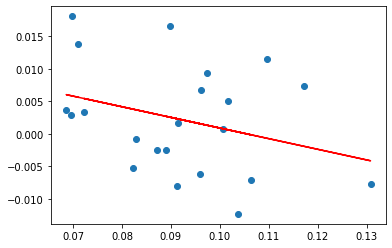

In [34]:
import numpy as np
x=datos['desocup']
y=datos['D.Infla']
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, color='red')